In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 874.1/874.1 kB 16.7 MB/s eta 0:00:00


In [ ]:
import os
import random
import shutil
import cv2
import glob
import yaml
import matplotlib.pyplot as plt
import ultralytics
import numpy as np
import torch
import xml.etree.ElementTree as ET
from torchvision import transforms
from tqdm import tqdm
from PIL import Image
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator

In [ ]:
ultralytics.checks()

Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 36.2/235.7 GB disk)


In [ ]:
!kaggle datasets download -d andrewmvd/hard-hat-detection

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/hard-hat-detection
License(s): CC0-1.0
 99% 1.21G/1.22G [00:05<00:00, 216MB/s]
100% 1.22G/1.22G [00:05<00:00, 249MB/s]


In [ ]:
!unzip -q /content/hard-hat-detection.zip

In [ ]:
# helmet_detection 디렉토리를 생성
data_root = '/content/helmet_detection'
# helmet_detection/data 디렉토리를 생성
file_root = f'{data_root}/data'
project_name = 'shd'

train_root = f'{data_root}/{project_name}/train'
valid_root = f'{data_root}/{project_name}/valid'
test_root = f'{data_root}/{project_name}/test'

In [ ]:
for folder in [train_root, valid_root, test_root]:
    if not os.path.exists(folder):
        os.makedirs(folder)
    for s in ['images', 'labels']:
        s_folder = f'{folder}/{s}'
        if not os.path.exists(s_folder):
            os.makedirs(s_folder)

In [ ]:
# helmet_detection/data 디렉토리에 images, annotations를 넣어줌
file_list = glob.glob(f'{file_root}/images/*.png')
len(file_list)

5000

In [ ]:
def xml_to_yolo_bbox(bbox, w, h):
    # xmin, ymin, xmax, ymax
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h
    return [x_center, y_center, width, height]

In [ ]:
# /content/helmet_detection/data/labels 디렉토리 생성

classes = []
for file in tqdm(file_list):
    file_name = file.split('/')[-1].replace('png', 'xml')
    save_name = file_name.replace('xml', 'txt')
    file_path = f'{file_root}/annotations/{file_name}'
    save_path = f'{file_root}/labels/{save_name}'

    result = list()
    tree = ET.parse(file_path)
    root = tree.getroot()
    width = int(root.find('size').find('width').text)
    height = int(root.find('size').find('height').text)
    for obj in root.findall('object'):
        label = obj.find('name').text
        if label not in classes:
            classes.append(label)
        index = classes.index(label)
        pil_bbox = [int(x.text) for x in obj.find('bndbox')]
        yolo_bbox = xml_to_yolo_bbox(pil_bbox, width, height)
        bbox_string = ' '.join([str(x) for x in yolo_bbox])
        result.append(f'{index} {bbox_string}')
    if result:
        with open(save_path, 'w', encoding='utf-8') as f:
            f.write('\n'.join(result))

100%|██████████| 5000/5000 [00:01<00:00, 3096.87it/s]


In [ ]:
classes

['helmet', 'head', 'person']

In [ ]:
cls_list = ['helmet', 'head', 'person']

In [ ]:
random.seed(2024)

In [ ]:
random.shuffle(file_list)
test_ratio = 0.1
num_file = len(file_list)

test_list = file_list[:int(num_file*test_ratio)]
valid_list = file_list[int(num_file*test_ratio):int(num_file*test_ratio)*2]
train_list = file_list[int(num_file*test_ratio)*2:]

In [ ]:
for i in test_list:
    label_name = i.split('/')[-1].replace('png', 'txt')
    label_path = f'{file_root}/labels/{label_name}'
    shutil.copyfile(label_path, f'{test_root}/labels/{label_name}')
    img_name = i.split('/')[-1]
    shutil.copyfile(i, f'{test_root}/images/{img_name}')

for i in valid_list:
    label_name = i.split('/')[-1].replace('png', 'txt')
    label_path = f'{file_root}/labels/{label_name}'
    shutil.copyfile(label_path, f'{valid_root}/labels/{label_name}')
    img_name = i.split('/')[-1]
    shutil.copyfile(i, f'{valid_root}/images/{img_name}')

for i in train_list:
    label_name = i.split('/')[-1].replace('png', 'txt')
    label_path = f'{file_root}/labels/{label_name}'
    shutil.copyfile(label_path, f'{train_root}/labels/{label_name}')
    img_name = i.split('/')[-1]
    shutil.copyfile(i, f'{train_root}/images/{img_name}')

In [ ]:
project_root = '/content/helmet_detection'

In [ ]:
data = dict()

data['train'] = train_root
data['val'] = valid_root
data['test'] = test_root
data['nc'] = len(cls_list)
data['names'] = cls_list

with open(f'{project_root}/safety_helmet.yaml', 'w') as f:
    yaml.dump(data, f)

In [ ]:
%cd /content/helmet_detection

/content/helmet_detection


In [ ]:
model = YOLO('yolov8n.pt')
# amp=False: 연산 성능을 최적화하기 위해 fp16(False), fp32(True) 중 선택
results = model.train(data='safety_helmet.yaml', epochs=2, batch=8, imgsz=224, device=0, workers=4, amp=False, patience=30, name='safety_n')

100%|██████████| 6.25M/6.25M [00:00<00:00, 124MB/s]


Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=safety_helmet.yaml, epochs=2, time=None, patience=30, batch=8, imgsz=224, save=True, save_period=-1, cache=False, device=0, workers=4, project=None, name=safety_n, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tru

100%|██████████| 755k/755k [00:00<00:00, 29.4MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/helmet_detection/shd/train/labels... 4000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4000/4000 [00:03<00:00, 1065.55it/s]


train: New cache created: /content/helmet_detection/shd/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/helmet_detection/shd/valid/labels... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<00:00, 760.38it/s]

val: New cache created: /content/helmet_detection/shd/valid/labels.cache


Plotting labels to runs/detect/safety_n/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/detect/safety_n
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2     0.382G      1.859      1.863      1.113         42        224: 100%|██████████| 500/500 [01:11<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.62it/s]


                   all        500       2407      0.858      0.405      0.465      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2     0.359G       1.65      1.207      1.044         32        224: 100%|██████████| 500/500 [01:11<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.98it/s]


                   all        500       2407      0.854      0.417      0.487      0.264

2 epochs completed in 0.045 hours.
Optimizer stripped from runs/detect/safety_n/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/safety_n/weights/best.pt, 6.2MB

Validating runs/detect/safety_n/weights/best.pt...
Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.33it/s]


                   all        500       2407      0.853      0.417      0.487      0.264
                helmet        452       1788      0.786      0.696      0.769      0.437
                  head         93        537      0.774      0.556      0.658       0.34
                person         15         82          1          0      0.035     0.0161
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/safety_n


In [ ]:
model = YOLO('yolov8s.pt')
# amp=False: 연산 성능을 최적화하기 위해 fp16(False), fp32(True) 중 선택
results = model.train(data='safety_helmet.yaml', epochs=50, batch=8, imgsz=224, device=0, workers=4, amp=False, patience=30, name='safety_s')

100%|██████████| 21.5M/21.5M [00:00<00:00, 240MB/s]


Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=safety_helmet.yaml, epochs=50, time=None, patience=30, batch=8, imgsz=224, save=True, save_period=-1, cache=False, device=0, workers=4, project=None, name=safety_s, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tr

train: Scanning /content/helmet_detection/shd/train/labels.cache... 4000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4000/4000 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/helmet_detection/shd/valid/labels.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]


Plotting labels to runs/detect/safety_s/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/detect/safety_s
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50     0.916G      1.681      1.376      1.102         42        224: 100%|██████████| 500/500 [01:18<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.63it/s]


                   all        500       2407      0.853       0.46      0.503      0.275

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      0.78G      1.619      1.096      1.071         32        224: 100%|██████████| 500/500 [01:08<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.69it/s]

                   all        500       2407       0.88      0.449      0.512      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50     0.782G      1.601       1.08      1.065         60        224: 100%|██████████| 500/500 [01:08<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  5.14it/s]

                   all        500       2407      0.526      0.476      0.527      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50     0.784G      1.563      1.035      1.054         50        224: 100%|██████████| 500/500 [01:08<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.25it/s]

                   all        500       2407      0.877      0.459      0.519      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50     0.782G      1.536      1.003      1.048         50        224: 100%|██████████| 500/500 [01:06<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.88it/s]

                   all        500       2407      0.898      0.483      0.539       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      0.78G      1.511     0.9796      1.035         31        224: 100%|██████████| 500/500 [01:06<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.09it/s]


                   all        500       2407      0.903      0.498      0.556      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50     0.782G        1.5     0.9723      1.029         48        224: 100%|██████████| 500/500 [01:05<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.31it/s]


                   all        500       2407      0.924      0.485      0.551      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50     0.782G      1.454       0.93      1.018         60        224: 100%|██████████| 500/500 [01:06<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.18it/s]


                   all        500       2407      0.905      0.501      0.556      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50     0.782G      1.445      0.919      1.013         65        224: 100%|██████████| 500/500 [01:05<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.83it/s]


                   all        500       2407       0.92      0.515      0.575       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50     0.782G      1.424     0.8966      1.007         60        224: 100%|██████████| 500/500 [01:06<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.83it/s]


                   all        500       2407       0.91      0.503       0.57      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50     0.782G      1.437      0.898      1.011         59        224: 100%|██████████| 500/500 [01:07<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  6.12it/s]


                   all        500       2407      0.914      0.519      0.584      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50     0.782G      1.403     0.8638      1.006         59        224: 100%|██████████| 500/500 [01:07<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.63it/s]


                   all        500       2407      0.912      0.525      0.575      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50     0.782G      1.399     0.8669     0.9995         60        224: 100%|██████████| 500/500 [01:09<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.01it/s]

                   all        500       2407      0.921      0.526      0.587      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50     0.782G      1.379      0.852     0.9967         37        224: 100%|██████████| 500/500 [01:07<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]

                   all        500       2407      0.899      0.531      0.579       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50     0.782G      1.372     0.8332     0.9946         67        224: 100%|██████████| 500/500 [01:08<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.21it/s]


                   all        500       2407      0.924      0.529      0.584      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50     0.782G      1.378     0.8388     0.9942         52        224: 100%|██████████| 500/500 [01:10<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.05it/s]

                   all        500       2407      0.922      0.535      0.589      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50     0.782G      1.349     0.8222     0.9837         60        224: 100%|██████████| 500/500 [01:10<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.10it/s]

                   all        500       2407      0.921      0.537      0.588       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50     0.782G      1.334      0.788     0.9712         56        224: 100%|██████████| 500/500 [01:10<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.88it/s]

                   all        500       2407      0.921      0.532      0.585      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50     0.782G      1.336     0.8022     0.9834         93        224: 100%|██████████| 500/500 [01:10<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  5.62it/s]

                   all        500       2407      0.932      0.519       0.59      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50     0.782G      1.319     0.7886     0.9819         77        224: 100%|██████████| 500/500 [01:07<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.35it/s]

                   all        500       2407      0.919      0.546      0.594      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50     0.782G      1.329     0.7942     0.9771         78        224: 100%|██████████| 500/500 [01:06<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.12it/s]

                   all        500       2407      0.931      0.529      0.593      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50     0.782G      1.321     0.7836     0.9759         93        224: 100%|██████████| 500/500 [01:06<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.08it/s]


                   all        500       2407      0.923      0.527      0.592      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50     0.782G      1.317     0.7769     0.9747         53        224: 100%|██████████| 500/500 [01:06<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  5.53it/s]


                   all        500       2407       0.93      0.536      0.588      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50     0.782G       1.29     0.7734     0.9711         54        224: 100%|██████████| 500/500 [01:07<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.87it/s]


                   all        500       2407      0.929      0.536      0.596      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50     0.782G      1.294     0.7629     0.9665         38        224: 100%|██████████| 500/500 [01:09<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.24it/s]


                   all        500       2407      0.927      0.541      0.599      0.371

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50     0.782G      1.299     0.7656       0.97         55        224: 100%|██████████| 500/500 [01:09<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.25it/s]

                   all        500       2407      0.933      0.537      0.598      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50     0.782G      1.285     0.7564     0.9691         47        224: 100%|██████████| 500/500 [01:10<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.00it/s]

                   all        500       2407      0.934      0.543      0.605       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50     0.782G       1.27     0.7537     0.9646         70        224: 100%|██████████| 500/500 [01:10<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.07it/s]

                   all        500       2407      0.926      0.544      0.597      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50     0.782G       1.28     0.7495     0.9666         55        224: 100%|██████████| 500/500 [01:10<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.98it/s]

                   all        500       2407      0.925      0.546      0.601      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50     0.782G       1.27     0.7472     0.9624         54        224: 100%|██████████| 500/500 [01:10<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.06it/s]


                   all        500       2407      0.928      0.547      0.604      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50     0.782G      1.259     0.7414     0.9622         67        224: 100%|██████████| 500/500 [01:10<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.79it/s]

                   all        500       2407       0.93      0.548      0.602      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50     0.782G      1.253     0.7308     0.9557         23        224: 100%|██████████| 500/500 [01:11<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.94it/s]


                   all        500       2407      0.927      0.546      0.602      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50     0.782G      1.242     0.7257     0.9582         50        224: 100%|██████████| 500/500 [01:10<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.97it/s]


                   all        500       2407      0.916      0.557      0.604      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50     0.782G      1.243     0.7219     0.9543         61        224: 100%|██████████| 500/500 [01:10<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.86it/s]

                   all        500       2407      0.934      0.551      0.604       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50     0.782G      1.234     0.7142     0.9589         49        224: 100%|██████████| 500/500 [01:11<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.73it/s]

                   all        500       2407      0.928      0.547      0.603      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50     0.782G      1.222     0.7017     0.9509         82        224: 100%|██████████| 500/500 [01:11<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]

                   all        500       2407      0.932      0.559      0.611      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50     0.782G       1.22     0.7051      0.949         35        224: 100%|██████████| 500/500 [01:11<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.90it/s]

                   all        500       2407      0.599      0.559      0.608      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50     0.782G      1.217     0.6929     0.9503         33        224: 100%|██████████| 500/500 [01:10<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.80it/s]

                   all        500       2407      0.928      0.563      0.611      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50     0.782G      1.213     0.6947     0.9446         52        224: 100%|██████████| 500/500 [01:10<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.88it/s]

                   all        500       2407      0.936       0.55      0.605      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50     0.782G      1.207     0.6774     0.9433         78        224: 100%|██████████| 500/500 [01:11<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.77it/s]

                   all        500       2407      0.593      0.556      0.607      0.385


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50     0.782G      1.162     0.6088      0.933         35        224: 100%|██████████| 500/500 [01:11<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.81it/s]

                   all        500       2407       0.61      0.549      0.609      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50     0.782G      1.145     0.5944     0.9315         35        224: 100%|██████████| 500/500 [01:08<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.79it/s]

                   all        500       2407      0.923      0.558      0.607      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50     0.782G      1.141     0.5837     0.9296         28        224: 100%|██████████| 500/500 [01:07<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  5.93it/s]

                   all        500       2407      0.929      0.556      0.609      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50     0.782G      1.136     0.5822      0.931         26        224: 100%|██████████| 500/500 [01:03<00:00,  7.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


                   all        500       2407      0.597       0.56      0.609       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50     0.782G      1.119     0.5731     0.9215         33        224: 100%|██████████| 500/500 [01:03<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  6.13it/s]

                   all        500       2407      0.597      0.564       0.61      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50     0.782G      1.124     0.5734     0.9258         36        224: 100%|██████████| 500/500 [01:05<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.36it/s]

                   all        500       2407      0.594       0.56      0.611      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50     0.782G      1.107     0.5627     0.9227         46        224: 100%|██████████| 500/500 [01:06<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  5.59it/s]

                   all        500       2407      0.596      0.563      0.612      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50     0.782G      1.101     0.5566     0.9184         30        224: 100%|██████████| 500/500 [01:04<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.44it/s]


                   all        500       2407      0.604      0.553      0.612      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50     0.782G      1.096     0.5588     0.9188         31        224: 100%|██████████| 500/500 [01:03<00:00,  7.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.17it/s]

                   all        500       2407      0.602      0.561      0.612      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50     0.782G      1.097     0.5495     0.9161         20        224: 100%|██████████| 500/500 [01:07<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.96it/s]

                   all        500       2407      0.606      0.557      0.613      0.396



50 epochs completed in 1.048 hours.
Optimizer stripped from runs/detect/safety_s/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/safety_s/weights/best.pt, 22.5MB

Validating runs/detect/safety_s/weights/best.pt...
Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


                   all        500       2407      0.607      0.557      0.613      0.396
                helmet        452       1788      0.926      0.843      0.925      0.604
                  head         93        537      0.894      0.828      0.896      0.577
                person         15         82          0          0     0.0174    0.00707
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/safety_s


In [ ]:
model = YOLO('yolov8m.pt')
# amp=False: 연산 성능을 최적화하기 위해 fp16(False), fp32(True) 중 선택
results = model.train(data='safety_helmet.yaml', epochs=50, batch=8, imgsz=224, device=0, workers=4, amp=False, patience=30, name='safety_m')

100%|██████████| 49.7M/49.7M [00:00<00:00, 351MB/s]


Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=safety_helmet.yaml, epochs=50, time=None, patience=30, batch=8, imgsz=224, save=True, save_period=-1, cache=False, device=0, workers=4, project=None, name=safety_m, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tr

train: Scanning /content/helmet_detection/shd/train/labels.cache... 4000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4000/4000 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/helmet_detection/shd/valid/labels.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]


Plotting labels to runs/detect/safety_m/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/detect/safety_m
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.84G      1.627      1.289      1.095         42        224: 100%|██████████| 500/500 [01:44<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.84it/s]

                   all        500       2407      0.861      0.445      0.489      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.52G      1.621      1.107      1.081         32        224: 100%|██████████| 500/500 [01:16<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.09it/s]

                   all        500       2407      0.854       0.47      0.513      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.53G      1.596      1.081      1.073         60        224: 100%|██████████| 500/500 [01:16<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.96it/s]


                   all        500       2407      0.884       0.44      0.504      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.53G      1.558      1.031      1.058         50        224: 100%|██████████| 500/500 [01:17<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.95it/s]

                   all        500       2407        0.9      0.478      0.541      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.53G      1.521     0.9964      1.048         50        224: 100%|██████████| 500/500 [01:17<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.92it/s]

                   all        500       2407      0.899      0.502       0.55      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.53G      1.488     0.9599      1.033         31        224: 100%|██████████| 500/500 [01:16<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.67it/s]


                   all        500       2407      0.917      0.488      0.557      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.53G      1.468     0.9428      1.027         48        224: 100%|██████████| 500/500 [01:16<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.97it/s]

                   all        500       2407      0.914      0.512      0.565      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.53G      1.432     0.9065      1.017         60        224: 100%|██████████| 500/500 [01:16<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.24it/s]

                   all        500       2407      0.925      0.514      0.573      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.53G      1.418      0.906      1.013         65        224: 100%|██████████| 500/500 [01:17<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.70it/s]

                   all        500       2407      0.925      0.518      0.584      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.53G      1.396     0.8703      1.006         60        224: 100%|██████████| 500/500 [01:17<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.82it/s]

                   all        500       2407      0.926      0.496      0.572      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.53G      1.402     0.8747      1.008         59        224: 100%|██████████| 500/500 [01:17<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.66it/s]

                   all        500       2407       0.91      0.526      0.584      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.53G       1.36     0.8432      1.002         59        224: 100%|██████████| 500/500 [01:19<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.74it/s]


                   all        500       2407      0.926      0.528      0.584      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.53G      1.356     0.8309     0.9971         60        224: 100%|██████████| 500/500 [01:17<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  5.34it/s]


                   all        500       2407      0.919      0.536      0.586      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.53G      1.351     0.8314     0.9954         37        224: 100%|██████████| 500/500 [01:17<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.61it/s]

                   all        500       2407      0.926      0.524      0.593      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.53G      1.335     0.8059      0.989         67        224: 100%|██████████| 500/500 [01:17<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.87it/s]

                   all        500       2407      0.927      0.536      0.591      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.53G      1.336     0.8093     0.9875         52        224: 100%|██████████| 500/500 [01:18<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.86it/s]

                   all        500       2407      0.935      0.545      0.609      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.53G      1.308     0.7926     0.9786         60        224: 100%|██████████| 500/500 [01:17<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.89it/s]

                   all        500       2407      0.932       0.53      0.596       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.53G      1.296     0.7701     0.9675         56        224: 100%|██████████| 500/500 [01:19<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  5.24it/s]

                   all        500       2407      0.919      0.546      0.598       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.53G      1.301     0.7734     0.9808         93        224: 100%|██████████| 500/500 [01:18<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  6.13it/s]


                   all        500       2407      0.927      0.543      0.596      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.53G      1.286     0.7672     0.9777         77        224: 100%|██████████| 500/500 [01:19<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.41it/s]

                   all        500       2407      0.934      0.554      0.609      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.53G       1.28     0.7617      0.971         78        224: 100%|██████████| 500/500 [01:17<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  5.31it/s]


                   all        500       2407      0.932      0.554        0.6      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.53G      1.278     0.7557     0.9717         93        224: 100%|██████████| 500/500 [01:17<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.98it/s]

                   all        500       2407      0.936      0.552      0.604      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.53G      1.277     0.7489     0.9687         53        224: 100%|██████████| 500/500 [01:17<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.32it/s]

                   all        500       2407      0.946      0.542      0.607      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.53G      1.247     0.7345     0.9661         54        224: 100%|██████████| 500/500 [01:16<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.92it/s]

                   all        500       2407      0.942       0.55      0.604      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.53G      1.253     0.7284      0.962         38        224: 100%|██████████| 500/500 [01:17<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.88it/s]


                   all        500       2407      0.937      0.556      0.612      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.53G      1.252     0.7304     0.9637         55        224: 100%|██████████| 500/500 [01:19<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.54it/s]

                   all        500       2407      0.943      0.548      0.608      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.53G      1.241     0.7249     0.9624         47        224: 100%|██████████| 500/500 [01:16<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.99it/s]


                   all        500       2407      0.947      0.544       0.61      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.53G      1.224      0.716     0.9575         70        224: 100%|██████████| 500/500 [01:17<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.97it/s]


                   all        500       2407      0.947       0.55      0.612      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.53G      1.237     0.7169     0.9601         55        224: 100%|██████████| 500/500 [01:18<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.89it/s]

                   all        500       2407      0.917      0.576      0.613      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.53G      1.222     0.7067     0.9545         54        224: 100%|██████████| 500/500 [01:20<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.78it/s]

                   all        500       2407      0.937      0.558      0.611      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.53G      1.221     0.7036     0.9598         67        224: 100%|██████████| 500/500 [01:17<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  6.22it/s]


                   all        500       2407      0.937      0.564      0.614      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.53G        1.2     0.6951     0.9488         23        224: 100%|██████████| 500/500 [01:18<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  5.21it/s]

                   all        500       2407      0.932      0.567      0.613      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.53G      1.195     0.6913     0.9526         50        224: 100%|██████████| 500/500 [01:20<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  6.25it/s]

                   all        500       2407      0.927      0.577      0.616      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.53G      1.196     0.6824     0.9486         61        224: 100%|██████████| 500/500 [01:16<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.65it/s]


                   all        500       2407      0.941      0.568      0.616      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.53G      1.181     0.6747     0.9511         49        224: 100%|██████████| 500/500 [01:17<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  5.27it/s]

                   all        500       2407      0.943      0.565      0.615      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.53G       1.18     0.6688     0.9455         82        224: 100%|██████████| 500/500 [01:17<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.77it/s]

                   all        500       2407      0.947      0.562      0.619      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.53G      1.171     0.6606     0.9426         35        224: 100%|██████████| 500/500 [01:15<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.88it/s]

                   all        500       2407      0.943      0.566      0.617      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.53G      1.166     0.6535     0.9419         33        224: 100%|██████████| 500/500 [01:17<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  4.00it/s]

                   all        500       2407      0.942      0.569      0.621      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.53G      1.159      0.655     0.9375         52        224: 100%|██████████| 500/500 [01:17<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.51it/s]


                   all        500       2407      0.594      0.571      0.617      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.53G      1.155     0.6361     0.9362         78        224: 100%|██████████| 500/500 [01:17<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  6.15it/s]

                   all        500       2407      0.942      0.558      0.614      0.393


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.53G      1.123     0.5739     0.9284         35        224: 100%|██████████| 500/500 [01:17<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.94it/s]

                   all        500       2407       0.61      0.561      0.618      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.53G      1.099     0.5588      0.924         35        224: 100%|██████████| 500/500 [01:21<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  5.93it/s]

                   all        500       2407      0.949      0.563      0.617      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.53G      1.093     0.5465     0.9222         28        224: 100%|██████████| 500/500 [01:24<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.07it/s]

                   all        500       2407      0.939      0.573      0.617      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.53G       1.09     0.5496     0.9213         26        224: 100%|██████████| 500/500 [01:20<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  5.10it/s]

                   all        500       2407      0.603      0.565      0.617      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.53G      1.074     0.5349      0.914         33        224: 100%|██████████| 500/500 [01:21<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.73it/s]


                   all        500       2407      0.609      0.565      0.619      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.53G      1.076     0.5342     0.9185         36        224: 100%|██████████| 500/500 [01:25<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  5.65it/s]

                   all        500       2407      0.602      0.588      0.619      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.53G      1.063     0.5242     0.9164         46        224: 100%|██████████| 500/500 [01:17<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  5.60it/s]

                   all        500       2407      0.619       0.56       0.62      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.53G      1.053     0.5215     0.9115         30        224: 100%|██████████| 500/500 [01:20<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.63it/s]

                   all        500       2407       0.62      0.563      0.622      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.53G      1.047     0.5184     0.9116         31        224: 100%|██████████| 500/500 [01:16<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.79it/s]

                   all        500       2407       0.62       0.56       0.62      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.53G      1.043     0.5106     0.9079         20        224: 100%|██████████| 500/500 [01:23<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.50it/s]

                   all        500       2407      0.611      0.567      0.622      0.407



50 epochs completed in 1.225 hours.
Optimizer stripped from runs/detect/safety_m/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/safety_m/weights/best.pt, 52.0MB

Validating runs/detect/safety_m/weights/best.pt...
Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  2.94it/s]


                   all        500       2407      0.611      0.567      0.622      0.407
                helmet        452       1788      0.948      0.855      0.943      0.623
                  head         93        537      0.885      0.847      0.906       0.59
                person         15         82          0          0     0.0166    0.00723
Speed: 0.2ms preprocess, 4.6ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/detect/safety_m


In [ ]:
%cd /content/helmet_detection

/content/helmet_detection


In [ ]:
result_folder = f'{project_root}/runs/detect'

* mAP(Mean Average Precision)
    * 객체 탐지 모델의 성능을 평가하는 대표적인 지표
    * 이미지 내에서 객체의 위치를 지정하는 바운딩 박스를 그리는 것이 포함
    * IoU(Intersection over Union)
        * 모델이 예측한 바운딩 박스와 실제 정답(ground truth) 바운딩 박스 사이의 겹치는 정도를 수치화한 값
        * (예측한 바운딩 박스와 실제 바운딩 박스의 교집합 영역) / (두 바운딩 박스의 합집합 영역)
        * 0에서 1사이의 값으로, 1에 가까울수록 예측과 실제가 잘 맞다는 뜻
* mAP50
    * IoU 임계값이 0.5일 때의 Mean Average Precision
    * 예측한 바운딩 박스와 실제 바운딩 박스 간의 IoU가 0.5 이상일 때를 성공으로 간주하여 평균 정밀도를 계산
    * IoU 0.5 이상일 때, 예측된 바운딩 박스가 "정확" 한 것으로 간주
    * 각 클래스(예: 자동차, 버스 ..)에 대한 AP를 계산하고, 모든 클래스의 평균값을 구하면 mAP50
    * 성능을 빠르게 평가할 수 있지만 엄격하지 않기 때문에 모델이 너무 관대하게 평가될 수 있음
* mAP50-95
    * IoU 임계값을 0.5에서 0.95까지 0.05단위로 변화시키면서 그때마다 AP를 계산한 뒤, 그 평균을 구하는 방식
    * IoU 0.5부터 0.95까지 다양한 IoU 임계값에서 성능을 평가하므로, 더 정확하고 엄격한 성능 평가 지표

In [ ]:
model = YOLO(f'{result_folder}/safety_n/weights/best.pt')
metrics = model.val(split='test')
print('mAP50', metrics.box.map50)
print('mAP50-95', metrics.box.map)

Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/helmet_detection/shd/test/labels.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.87it/s]


                   all        500       2641      0.839      0.409      0.465      0.248
                helmet        466       2053      0.769       0.71      0.763      0.424
                  head         85        475      0.747      0.516       0.62      0.317
                person         21        113          1          0     0.0132     0.0041
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/detect/val4
mAP50 0.46510072386101103
mAP50-95 0.24839207024076007


In [ ]:
model = YOLO(f'{result_folder}/safety_s/weights/best.pt')
metrics = model.val(split='test')
print('mAP50', metrics.box.map50)
print('mAP50-95', metrics.box.map)

Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/helmet_detection/shd/test/labels.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.26it/s]


                   all        500       2641      0.596      0.549      0.601      0.384
                helmet        466       2053      0.913      0.854      0.925      0.601
                  head         85        475      0.875      0.794      0.862      0.542
                person         21        113          0          0     0.0171    0.00825
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/val5
mAP50 0.60129324707195
mAP50-95 0.3836371848165581


In [ ]:
model = YOLO(f'{result_folder}/safety_m/weights/best.pt')
metrics = model.val(split='test')
print('mAP50', metrics.box.map50)
print('mAP50-95', metrics.box.map)

Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /content/helmet_detection/shd/test/labels.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.85it/s]


                   all        500       2641      0.636      0.565      0.614      0.396
                helmet        466       2053      0.927      0.875      0.937      0.616
                  head         85        475      0.869      0.812      0.879      0.557
                person         21        113      0.113    0.00885     0.0276     0.0139
Speed: 0.3ms preprocess, 4.7ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/val6
mAP50 0.6143894994286884
mAP50-95 0.3956736084836311


In [ ]:
data_root = '/content/helmet_detection'
project_name = 'shd'
test_root = f'{data_root}/{project_name}/test'
test_file_list = glob.glob(f'{test_root}/images/*')
random.shuffle(test_file_list)

In [ ]:
IMG_SIZE = (224, 224)
test_data_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()
])

In [ ]:
model.names

{0: 'helmet', 1: 'head', 2: 'person'}

In [ ]:
color_dict = {i: tuple([random.randint(0, 255) for _ in range(3)]) for i in range(len(model.names))}
color_dict

{0: (4, 174, 162), 1: (164, 18, 75), 2: (131, 79, 194)}

In [ ]:
test_img = cv2.imread(test_file_list[3])
img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
result = model(img_src)


0: 224x224 3 helmets, 26.4ms
Speed: 1.7ms preprocess, 26.4ms inference, 6.6ms postprocess per image at shape (1, 3, 224, 224)


In [ ]:
result[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0., 0., 0.], device='cuda:0')
conf: tensor([0.6149, 0.5243, 0.4114], device='cuda:0')
data: tensor([[194.8336, 101.5821, 208.8749, 119.2206,   0.6149,   0.0000],
        [200.3374,  58.6689, 217.5769,  77.6673,   0.5243,   0.0000],
        [230.5855, 106.4636, 246.2361, 124.4069,   0.4114,   0.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (416, 416)
shape: torch.Size([3, 6])
xywh: tensor([[201.8543, 110.4014,  14.0413,  17.6385],
        [208.9572,  68.1681,  17.2395,  18.9984],
        [238.4108, 115.4353,  15.6507,  17.9433]], device='cuda:0')
xywhn: tensor([[0.4852, 0.2654, 0.0338, 0.0424],
        [0.5023, 0.1639, 0.0414, 0.0457],
        [0.5731, 0.2775, 0.0376, 0.0431]], device='cuda:0')
xyxy: tensor([[194.8336, 101.5821, 208.8749, 119.2206],
        [200.3374,  58.6689, 217.5769,  77.6673],
        [230.5855, 106.4636, 246.2361, 124.4069]], device='cuda:0')
xyxyn: tensor([[0.4684, 0.2442, 0.50

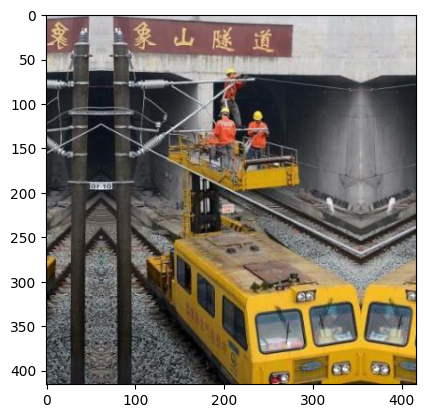

In [ ]:
plt.imshow(img_src)
plt.show()


0: 224x224 3 helmets, 53.8ms
Speed: 1.2ms preprocess, 53.8ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 224)


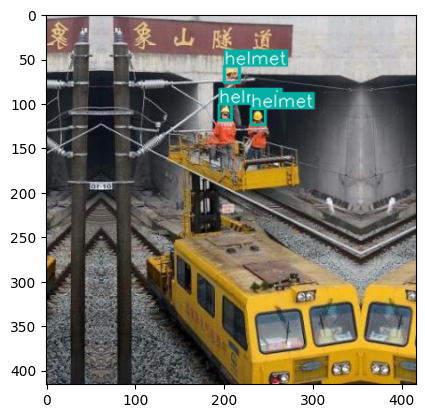

In [ ]:
num_head = 0
test_img = cv2.imread(test_file_list[3])
img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
result = model(img_src)[0]

annotator = Annotator(img_src)
boxes = result.boxes

for box in boxes:
    b = box.xyxy[0]
    cls = box.cls
    if 'head' == model.names[int(cls)]:
        num_head += 1
    annotator.box_label(b, model.names[int(cls)], color_dict[int(cls)])
img_src = annotator.result()
if num_head > 0:
    cv2.rectangle(img_src, (0, 0), (300, 50), (255, 0, 0), -1, cv2.LINE_AA)
    cv2.putText(img_src, 'No Helmet!', (5, 30), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), lineType=cv2.LINE_AA)

plt.imshow(img_src)
plt.show()

In [ ]:
plt.figure(figsize=(20, 16))

for idx in range(20):
    num_head = 0
    test_img = cv2.imread(test_file_list[idx])
    img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    result = model(img_src)[0]

    annotator = Annotator(img_src)
    boxes = result.boxes

    for box in boxes:
        b = box.xyxy[0]
        cls = box.cls
        if 'head' == model.names[int(cls)]:
            num_head += 1
        annotator.box_label(b, model.names[int(cls)], color_dict[int(cls)])
    img_src = annotator.result()

    plt.subplot(5, 4, (idx+1))
    if num_head > 0:
        cv2.rectangle(img_src, (0, 0), (300, 50), (255, 0, 0), -1, cv2.LINE_AA)
        cv2.putText(img_src, 'No Helmet!', (5, 30), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), lineType=cv2.LINE_AA)

    plt.imshow(img_src)
plt.show()